In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import time
from scipy.spatial import distance
import time
import math
%matplotlib inline
import matplotlib.cm as cm
from matplotlib.colors import Normalize


In [66]:
from sklearn.cluster import KMeans

In [5]:
def check_ok(c,r,circles):
    # check if new circle center/radius satisfied gamma margin
    for curr_c,curr_r in circles.items():
        #if (distance.euclidean(c,curr_c) - curr_c['radius']) <= (gamma * r):
        if distance.euclidean(c,curr_c) <= (curr_r['radius'] + gamma*r):
            return False
        else:
            print "%s bigger than %s"%(distance.euclidean(c,curr_c),(curr_r['radius'] + gamma*r))
            print("need rad %s, got rad %s"%(gamma*r,distance.euclidean(c,curr_c)-curr_r['radius']))
            
    return True

In [6]:
def gen_on_circle(c,r):
    """
    Generate random point on circumfrence of circle
    """
    angle = np.random.rand()*np.pi* 2
    x = c[0]+r*np.cos(angle)
    y = c[1]+r*np.sin(angle)

    return x,y

def find_center(c,r,gamma,r_new):
    """
    Find the new center
    """
    is_inside=False
    bubble_dist = gamma*r_new
    while not is_inside:
        dir_x,dir_y = gen_on_circle(c,r)
        new_x= dir_x + (dir_x-c[0]) / r * bubble_dist
        new_y = dir_y + (dir_y-c[1]) / r * bubble_dist
        is_inside=True
        break
        if new_x < wid and new_y < ht and new_x >= 0 and new_y >=0:
            #print "original rad %s, calc rad: %s, bubble rad: %s"%(r,distance.euclidean((dir_x,dir_y),c),\
            #                                                       distance.euclidean((new_x,new_y),c))
            is_inside=True
    return new_x, new_y

In [7]:
def gen_circle(circles):
    found=False
    start=time.time()
    while not found:
        r = np.random.randint(rmin,rmax)
        if not circles:
            x = np.random.randint(r,wid-r)
            y = np.random.randint(r,ht-r)
        else:
            # get random circle
            r_c, r_r = random.choice(list(circles.items()))
            x,y = find_center(r_c,r_r['radius'],gamma,r)
        found=check_ok((x,y),r,circles)
    return (x,y),r

In [8]:
def gen_point(c,r):
    valid=False
    while not valid:
        p_x=np.random.randint(max(0,c[0]-r),min(c[0]+r,wid))
        p_y=np.random.randint(max(0,c[1]-r),min(c[1]+r,ht))
        valid=(((p_x-c[0])**2 + (p_y-c[1])** 2)<=(r**2))
    return [p_x,p_y]

In [9]:
def generate_points(c,r,npoints=50):
    """
    Generate poitns in a circle
    """
    points = [gen_point(c,r) for x in xrange(npoints)]
    return np.array(points)

In [10]:
def create_all_circles(k):
    circles={}
    while len(circles) < k:
        c,r = gen_circle(circles)
        circles[c]={'radius':r}

    return circles

In [44]:
norm = Normalize(vmin=0, vmax=k)
cmap = cm.hot

In [45]:
wid=500
ht=500

In [291]:
gamma=1.3
rmin=10
rmax=50
k=4
npoints = 200

In [292]:
circles = create_all_circles(k)

51.4 bigger than 51.4
need rad 23.4, got rad 23.4
58.517061699 bigger than 41.0
need rad 13.0, got rad 30.517061699
83.6950043565 bigger than 43.6
need rad 15.6, got rad 55.6950043565
64.5273580859 bigger than 64.4
need rad 36.4, got rad 36.5273580859
54.4 bigger than 54.4
need rad 36.4, got rad 36.4
65.7 bigger than 65.7
need rad 37.7, got rad 37.7
98.6798462685 bigger than 55.7
need rad 37.7, got rad 80.6798462685
129.612434955 bigger than 65.7
need rad 37.7, got rad 101.612434955


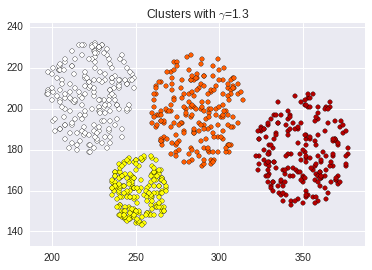

In [293]:
samples_df = pd.DataFrame()
i=0
for c,r in circles.items():
    
    points=generate_points(c,r['radius'],npoints=npoints)
    curr = pd.DataFrame(points,columns=['x','y'])
    curr['c_x'],curr['c_y']=c
    curr['ind']=i
    samples_df=pd.concat([samples_df,curr]) if len(samples_df)>0 else curr
    i+=1
    plt.scatter(points[:,0],points[:,1],c=cmap(norm(i)))
    plt.xlim(min(samples_df.x)-10,max(samples_df.x)+10)
    plt.ylim(min(samples_df.y)-10,max(samples_df.y)+10)
samples_df = samples_df.reset_index(drop=True)
plt.title("Clusters with $\gamma$=%s"%gamma)
plt.savefig('./project_viz/clust_%s.png'%gamma)

In [294]:
clf = KMeans(n_clusters=k)
clf.fit(samples_df[['x','y']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [295]:
samples_df['kmeans_pred']=clf.labels_

In [296]:
b = samples_df.groupby(['ind','kmeans_pred']).count().sort_index(level=['ind','kmeans_pred'],ascending=False).reset_index()
map_kmeans = b.sort(['ind','x'],ascending=False).groupby(['ind']).first()['kmeans_pred']

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [297]:
samples_df['kmeans_common']=samples_df['ind'].apply(lambda x: map_kmeans[x])
samples_df['misclassified']=samples_df['kmeans_pred']!=samples_df['kmeans_common']

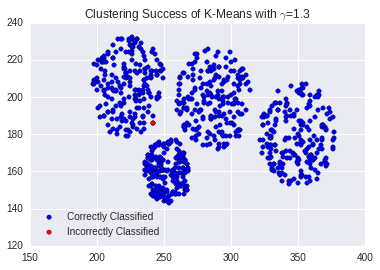

In [298]:
plt.scatter(samples_df.x,samples_df.y,c='blue',label='Correctly Classified')
wrong = samples_df[samples_df.misclassified]
plt.scatter(wrong.x,wrong.y,c='red',label='Incorrectly Classified')
plt.legend(loc=3)
plt.title("Clustering Success of K-Means with $\gamma$=%s"%gamma)
plt.savefig('./project_viz/kmeans_g%s.png'%(str(gamma).replace(".","")))

In [299]:
def ssac(df,k,gamma_e,delta=0.1,beta=1.1):
    clusters = {}
    new = df.copy()
    plt.scatter(samples_df.x,samples_df.y,c='w',label='Not Sampled')
    norm = Normalize(vmin=0, vmax=k)
    cmap = cm.hot
    assns_made = 0
    for i in range(k):
        const = (np.log(k-i)+np.log(1./delta))/((gamma_e-1.)**4)
        print const
        eta = beta*const
        print("eta = %.2f; const = %.2f"%(eta,const))
        l = int((k-i)* eta + 1)
        samps = pd.DataFrame()
        while (len(samps)==0 or samps.groupby('ind').count().sort('x',ascending=False).iloc[0].x <= eta):
            exc = new[~new.isin(samps)].dropna().reset_index(drop=True)
            ind = np.random.choice(np.arange(0,len(exc)),size=1,replace=False)
            samps = pd.concat([samps,exc.loc[ind]]).reset_index(drop=True)
            exc = exc.loc[~exc.index.isin(ind)]
            assns_made+=1
        
        assigned_clust = samps.groupby('ind').count().sort('x',ascending=False).iloc[0].name
        keep = samps[samps.ind==assigned_clust]
        
        appx_center = (keep.mean().x, keep.mean().y)
        
        plt.scatter(keep['x'],keep['y'],c=cmap(norm(i)))
        plt.scatter(appx_center[0],appx_center[1],c='blue')
        plt.scatter(keep.iloc[0].c_x,keep.iloc[0].c_y,c='green')
        # PHASE 2
        new['d_appx_cent']=new[['x','y']].apply(lambda r: distance.euclidean((r['x'],r['y']),appx_center),axis=1)
        print appx_center
        
        new = new.sort(['d_appx_cent']).reset_index(drop=True)

        # binary search (not really)
        appx_r = new.groupby(['ind']).last().sort('d_appx_cent').iloc[0].d_appx_cent
        clust = new[new.d_appx_cent<= appx_r]
        if len(clust.ind.unique())>1:
            print 'Impure'
        clusters[assigned_clust]=clust[clust.ind!=assigned_clust]
        new = new[new.d_appx_cent > appx_r].reset_index(drop=True)
        samps = pd.merge(samps,new)
        print("Total Assignments Made = %s"%assns_made)

    
    plt.title("Points Assigned with Cluster-Assignment Queries (#Qu=%s)"%assns_made)
    plt.scatter(appx_center[0],appx_center[1],c='blue',label='Appx. Center')
    plt.scatter(keep.iloc[0].c_x,keep.iloc[0].c_y,c='green',label='True Center')
    plt.legend(loc=3)
    plt.savefig("./project_viz/cl_recovery_apgam%s_gam%s.png"%(str(gamma_e).replace(".",""),str(gamma).replace(".","")))
    return clusters

In [302]:
gamma_est = 1.3

In [303]:
def calc_const(k,gamma,delta=0.1):
    return (np.log(k)+np.log(1./delta))/((gamma-1.)**4)

319.786069808
eta = 351.76; const = 319.79


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:34: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:37: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(222.46306818181819, 205.70738636363637)
Total Assignments Made = 653
284.269764567
eta = 312.70; const = 284.27
(350.2843450479233, 178.94249201277955)
Total Assignments Made = 1148
234.212343813
eta = 257.63; const = 234.21
(248.49612403100775, 159.3217054263566)
Total Assignments Made = 1474
148.638617818
eta = 163.50; const = 148.64
(294.14024390243901, 205.22560975609755)
Total Assignments Made = 1638


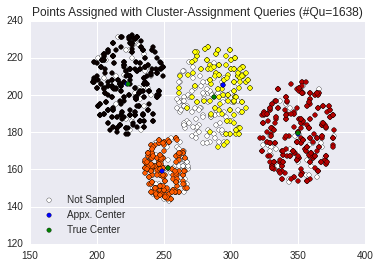

In [304]:
cl = ssac(samples_df,k,gamma_est,delta=0.3,beta=1.1)

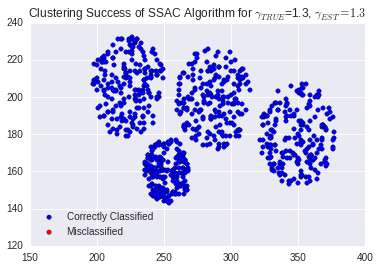

In [305]:
plt.scatter(samples_df.x,samples_df.y,label='Correctly Classified')
misclass = pd.concat(cl.values())
plt.scatter(misclass.x,misclass.y,c='red',label='Misclassified')
plt.legend(loc=3)
plt.title("Clustering Success of SSAC Algorithm for $\gamma_{TRUE}$=%s, $\gamma_{EST}=%s$"%(gamma,gamma_est))
plt.savefig("./project_viz/ssrc_mis_t%s_a%s"%(str(gamma).replace(".",""),str(gamma_est).replace(".","")))

In [228]:
x = np.arange(1.01,2,0.05)

In [229]:
delta = np.arange(0.001,0.2,0.03)

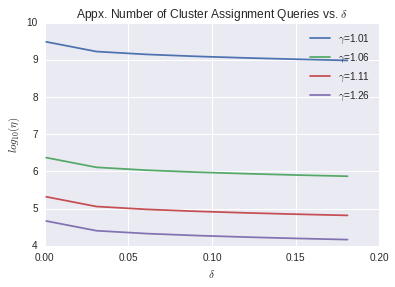

In [231]:
plt.plot(delta,([math.log(k*calc_const(2,x[0],delta=d),10) for d in delta]),label='$\gamma$=%s'%x[0])
plt.plot(delta,([math.log(k*calc_const(2,x[1],delta=d),10) for d in delta]),label='$\gamma$=%s'%x[1])
plt.plot(delta,([math.log(k*calc_const(2,x[2],delta=d),10) for d in delta]),label='$\gamma$=%s'%x[2])
plt.plot(delta,([math.log(k*calc_const(2,x[3],delta=d),10) for d in delta]),label='$\gamma$=%s'%x[5])
plt.xlabel('$\delta$')
plt.ylabel("$log_{10} (\eta)$")
plt.title("Appx. Number of Cluster Assignment Queries vs. $\delta$")
plt.legend()
plt.savefig('./project_viz/clust_assn_gar.png')

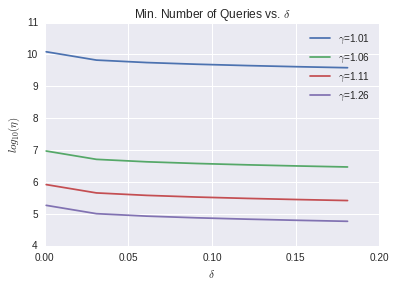

In [234]:
plt.plot(delta,([math.log(k*k*calc_const(2,x[0],delta=d),10) for d in delta]),label='$\gamma$=%s'%x[0])
plt.plot(delta,([math.log(k*k*calc_const(2,x[1],delta=d),10) for d in delta]),label='$\gamma$=%s'%x[1])
plt.plot(delta,([math.log(k*k*calc_const(2,x[2],delta=d),10) for d in delta]),label='$\gamma$=%s'%x[2])
plt.plot(delta,([math.log(k*k*calc_const(2,x[3],delta=d),10) for d in delta]),label='$\gamma$=%s'%x[5])
plt.xlabel('$\delta$')
plt.ylabel("$log_{10} (\eta)$")
plt.title("Min. Number of Queries vs. $\delta$")
plt.legend()
plt.savefig("./project_viz/minq.png")